In [1]:
import xenaPython as xena
import pandas as pd
import numpy as np
import random
from urllib.error import HTTPError

C:\Users\Tallon\anaconda3\lib\site-packages\xenaPython\__init__.py:110: FutureWarning: Possible nested set at position 7
  re.sub(r"^[^[]+[[]([^]]*)[]].*$", r"\1", query, flags=re.DOTALL))


In [2]:
#GDC TCGA datasets
#code:        DatasetID:
acc_Cancer  = 'TCGA-ACC.htseq_fpkm.tsv'
chol_Cancer = 'TCGA-CHOL.htseq_fpkm.tsv'
blca_Cancer = 'TCGA-BLCA.htseq_fpkm.tsv'
brca_Cancer = 'TCGA-BRCA.htseq_fpkm.tsv'
cesc_Cancer = 'TCGA-CESC.htseq_fpkm.tsv'

coad_Cancer = 'TCGA-COAD.htseq_fpkm.tsv'
ucec_Cancer = 'TCGA-UCEC.htseq_fpkm.tsv'
esca_Cancer = 'TCGA-ESCA.htseq_fpkm.tsv'
hnsc_Cancer = 'TCGA-HNSC.htseq_fpkm.tsv'
lihc_Cancer = 'TCGA-LIHC.htseq_fpkm.tsv'

ov_Cancer   = 'TCGA-OV.htseq_fpkm.tsv'
paad_Cancer = 'TCGA-PAAD.htseq_fpkm.tsv'
prad_Cancer = 'TCGA-PRAD.htseq_fpkm.tsv'
read_Cancer = 'TCGA-READ.htseq_fpkm.tsv'
stad_Cancer = 'TCGA-STAD.htseq_fpkm.tsv'

tgct_Cancer = 'TCGA-TGCT.htseq_fpkm.tsv'
thca_Cancer = 'TCGA-THCA.htseq_fpkm.tsv'

links = [acc_Cancer, chol_Cancer, blca_Cancer,brca_Cancer, cesc_Cancer, coad_Cancer, 
         ucec_Cancer, esca_Cancer, hnsc_Cancer, lihc_Cancer, ov_Cancer, paad_Cancer, 
         prad_Cancer, read_Cancer, stad_Cancer, tgct_Cancer, thca_Cancer]

In [3]:
#The hub of the dataset will be at the top of the page
hub = "https://gdc.xenahubs.net"
dataset = "TARGET-ALL-P3.htseq_fpkm.tsv"

#command to get the sampleIDs of the dataset
samples = xena.dataset_samples (hub, dataset, None)
#print(samples)

#command to get the fields/Identifiers of the dataset
identifiers = xena.dataset_field (hub, dataset)
identifiers.remove('sampleID')
print(identifiers[:10])

#command to get the data of the dataset
position, data = xena.dataset_probe_values (hub, dataset, samples, identifiers[:10])

#Use pandas to get the data in table form and transpose it, so data is grouped by samples and not identifers.
pdData = pd.DataFrame(data).T
len(pdData)


['ENSG00000000003.13', 'ENSG00000000005.5', 'ENSG00000000419.11', 'ENSG00000000457.12', 'ENSG00000000460.15', 'ENSG00000000938.11', 'ENSG00000000971.14', 'ENSG00000001036.12', 'ENSG00000001084.9', 'ENSG00000001167.13']


135

In [4]:
def getDataTable(dataset, sample_size):
    hub = 'https://gdc.xenahubs.net'
    samples = xena.dataset_samples (hub, dataset, None)
    
    if(sample_size < len(samples)):
        samples = random.sample(samples, sample_size)
        
    
    identifiers = xena.dataset_field (hub, dataset)
    identifiers.remove('sampleID')
    position, dataAsList = xena.dataset_probe_values (hub, dataset, samples, identifiers)
    
    data = pd.DataFrame(dataAsList).T
    
    return (samples, identifiers, data)

In [5]:
def collectAllData(links, sampleCountPerDB):
    
    data = pd.DataFrame()
    identifiers = []
    samples = []
    cancer_types = []
    
    for l in links:
        i = 0
        while True:
            print(l, " attempt: ", (i+1))
            try:
                l_samples, l_idif, l_data = getDataTable(l, sampleCountPerDB)
                data = data.append(l_data, ignore_index = True)
                identifiers = l_idif
                samples += l_samples
                cancer_types += [l[5:l.find('.')]]*len(l_samples)
                
            except HTTPError:
                if(i > 3):
                    break
                else:
                    i+=1
                    continue
            break
            
    return samples, identifiers, cancer_types, data
    
    

In [6]:
def selectCancerType(cancer_type, cancer_types_list):
    notString = 'Not'+cancer_type
    new_types_List = [] 
    
    for i in range(len(cancer_types_list)):
        t = cancer_types_list[i]
        if(t != cancer_type):
            new_types_List.append(notString)
        else:
            new_types_List.append(cancer_type)
        
    
    return new_types_List

In [7]:
from sklearn.feature_selection import VarianceThreshold

def getVarianceMask(variance, data):
    sel = VarianceThreshold(threshold=variance)
    sel.fit(data.values)
    return sel.get_support()


In [8]:
from sklearn.feature_selection import SelectKBest, chi2

def getBestKMask(k, data, cancer_types):
    sel = SelectKBest(chi2, k)
    sel.fit(data, cancer_types)
    return sel.get_support()
    

In [9]:
def createFeatureMask(desiredFeatureIndexList, features):
    mask = []
    for i in range(len(features)):
        if(i in desiredFeatureIndexList):
            mask.append(True)
        else:
            mask.append(False)
            
    return mask

In [10]:
from matplotlib import pyplot as plt
from sklearn import svm

def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

In [11]:
from sklearn import tree
import graphviz

def decisionTreeTask(data, identifiers, cancer_types, max_depth, selected_name):
    
    clf = tree.DecisionTreeClassifier(max_depth = max_depth)
    clf.fit(data, cancer_types)
    
    dot_data = tree.export_graphviz(clf, out_file=None, feature_names = identifiers, 
                                    class_names = np.unique(np.array(cancer_types)), 
                                    filled=True, rounded=True, special_characters=True)
    graph = graphviz.Source(dot_data, format="png")
    #graph.render("./")
    
    textTree = tree.export_text(clf, feature_names = identifiers)
    
    # n features of highest importance
    n = 10

    # index of most important n features.
    most_important_features = sorted(range(len(clf.feature_importances_)), key = lambda sub: clf.feature_importances_[sub])[-n:]
    
    return graph, textTree, most_important_features

In [12]:
from matplotlib import pyplot as plt
from sklearn import svm

def getSVMFeatures(sample_types, identifiers, data, mask):
    
    feature_names = np.array(identifiers)[mask]
    masked_data = data[:,mask].tolist()
    
    svm_ = svm.SVC(kernel='linear')
    svm_.fit(masked_data, sample_types)
    
    return svm_.coef_, feature_names

In [13]:
def getAnalysis(data, samples, identifiers, cancer_types, selected_cancer, n_kfiltered, max_depth, top_n_features):
    
    #Selecting Target Cancer
    if(selected_cancer != ''):
        targetList = selectCancerType(selected_cancer, cancer_types)
    else:
        targetList = cancer_types
    
    #Filtering Features
    kMask = getBestKMask(n_kfiltered, data, targetList)
    filteredIdentifiers = np.array(identifiers)[kMask]
    filteredData = data.values[:,kMask]
    
    #Fitting Decision Tree
    graph, textTree, most_important_features = decisionTreeTask(filteredData.tolist(), filteredIdentifiers.tolist(), 
                                                                targetList, max_depth, selected_cancer)
    
    #Getting Mask to filter only the most important features
    finalMask = createFeatureMask(most_important_features, filteredIdentifiers.tolist())
    
    #Applying SVM to important features
    coefs, feature_names = getSVMFeatures(targetList, filteredIdentifiers, filteredData, finalMask)
    
    #f_importances(coefs[0].tolist(), feature_names.tolist())
    
    
    return graph, textTree, coefs[0].tolist(), feature_names.tolist()
    
    

In [14]:
samples, identifiers, cancer_types, data = collectAllData(links, 40)

TCGA-ACC.htseq_fpkm.tsv  attempt:  1
TCGA-CHOL.htseq_fpkm.tsv  attempt:  1
TCGA-BLCA.htseq_fpkm.tsv  attempt:  1
TCGA-BRCA.htseq_fpkm.tsv  attempt:  1
TCGA-BRCA.htseq_fpkm.tsv  attempt:  2
TCGA-CESC.htseq_fpkm.tsv  attempt:  1
TCGA-COAD.htseq_fpkm.tsv  attempt:  1
TCGA-UCEC.htseq_fpkm.tsv  attempt:  1
TCGA-ESCA.htseq_fpkm.tsv  attempt:  1
TCGA-HNSC.htseq_fpkm.tsv  attempt:  1
TCGA-LIHC.htseq_fpkm.tsv  attempt:  1
TCGA-OV.htseq_fpkm.tsv  attempt:  1
TCGA-PAAD.htseq_fpkm.tsv  attempt:  1
TCGA-PRAD.htseq_fpkm.tsv  attempt:  1
TCGA-READ.htseq_fpkm.tsv  attempt:  1
TCGA-STAD.htseq_fpkm.tsv  attempt:  1
TCGA-TGCT.htseq_fpkm.tsv  attempt:  1
TCGA-THCA.htseq_fpkm.tsv  attempt:  1


In [39]:
graph, textTree, coefs, feature_names = getAnalysis(data, samples, identifiers, cancer_types, 'OV', 100, 10, 10)

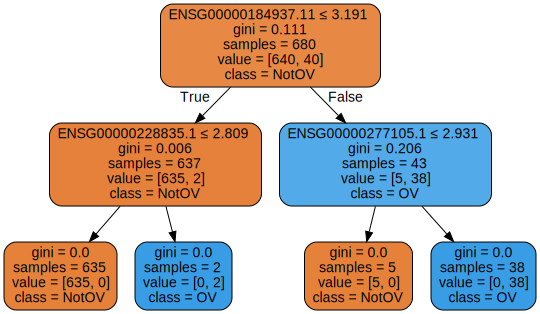

In [40]:
graph

In [41]:
textTree

'|--- ENSG00000184937.11 <= 3.19\n|   |--- ENSG00000228835.1 <= 2.81\n|   |   |--- class: NotOV\n|   |--- ENSG00000228835.1 >  2.81\n|   |   |--- class: OV\n|--- ENSG00000184937.11 >  3.19\n|   |--- ENSG00000277105.1 <= 2.93\n|   |   |--- class: NotOV\n|   |--- ENSG00000277105.1 >  2.93\n|   |   |--- class: OV\n'

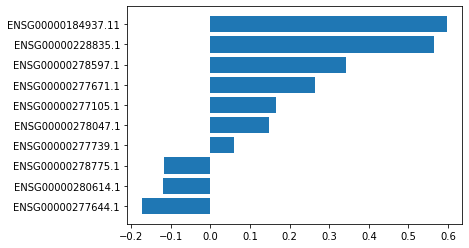

In [42]:
f_importances(coefs, feature_names)